In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import math
import operator
import csv

In [67]:
pd.options.display.max_colwidth = 250

In [68]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    'LazarusNLP/all-indobert-base-v4')

In [69]:
# Membaca file madaniyah.csv untuk mendapatkan nomor surah
madaniyah_chapters = []
with open('/content/drive/MyDrive/google-quran-translate-evaluation/madaniyah.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Melewati header
    for row in csv_reader:
        madaniyah_chapters.append(int(row[1]))

In [70]:
sentences = []

for chapter in madaniyah_chapters:

  google_translate = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/data/google_translate/chapter_' + str(chapter) + '.csv')
  kemenag = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/data/kemenag/chapter_' + str(chapter) + '.csv')
  king_fahd = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/data/king_fahd/chapter_' + str(chapter) + '.csv')

  sentence1 = google_translate['google_translate'].tolist()
  sentence2 = kemenag['kemenag'].tolist()
  sentence3 = king_fahd['king_fahd'].tolist()

  sentences.append(sentence1)
  sentences.append(sentence2)
  sentences.append(sentence3)


sentence_new = []
for i in range(0, len(sentences)):
  for j in range(0, len(sentences[i])):
    sentence_new.append(sentences[i][j])

sentence_embeddings = model.encode(sentence_new)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [71]:
sentence_embeddings.shape

(3891, 768)

In [82]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Inisialisasi
index_map = []
current_index = 0
df = pd.DataFrame(columns=[
    'Chapter', 'Verse', 'Google Translate', 'Kemenag', 'King Fahd',
    'Fahd - Google', 'Kemenag - Google', 'Fahd - Kemenag'
])

# Bangun peta indeks untuk masing-masing surah
for chapter in madaniyah_chapters:
    df_chapter = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/data/google_translate/chapter_{chapter}.csv')

    # Ambil jumlah ayat
    n_verses = len(df_chapter)

    # Simpan kolom nomor ayat
    if 'nomor_ayat' in df_chapter.columns:
        verses = df_chapter['nomor_ayat'].tolist()
    elif 'verse_number' in df_chapter.columns:
        verses = df_chapter['verse_number'].tolist()
    else:
        raise ValueError(f'Kolom nomor ayat tidak ditemukan di surah {chapter}')

    index_map.append({
        'chapter': chapter,
        'start_index': current_index,
        'num_verses': n_verses,
        'verses': verses
    })

    current_index += 3 * n_verses  # 3 versi: fahd, kemenag, google

# Loop seluruh surah dan ayat untuk hitung similarity
for mapping in index_map:
    chapter = mapping['chapter']
    start = mapping['start_index']
    n_verses = mapping['num_verses']
    verses = mapping['verses']

    for idx, verse_num in enumerate(verses):
        i_google = start + idx
        i_kemenag = start + n_verses + idx
        i_fahd    = start + 2 * n_verses + idx

        # Hitung cosine similarity
        sim_fahd = cosine_similarity([sentence_embeddings[i_fahd]], [sentence_embeddings[i_google]])[0][0]
        sim_kemenag = cosine_similarity([sentence_embeddings[i_kemenag]], [sentence_embeddings[i_google]])[0][0]
        sim_fahd_kemenag = cosine_similarity([sentence_embeddings[i_fahd]], [sentence_embeddings[i_kemenag]])[0][0]

        dict_row = {
            'Chapter': chapter,
            'Verse': verse_num,  # ← langsung dari file
            'Google Translate': sentence_new[i_google],
            'Kemenag': sentence_new[i_kemenag],
            'King Fahd': sentence_new[i_fahd],
            'Fahd - Google': sim_fahd,
            'Kemenag - Google': sim_kemenag,
            'Fahd - Kemenag': sim_fahd_kemenag
        }

        df = pd.concat([df, pd.DataFrame([dict_row])], ignore_index=True)

# Tampilkan hasil akhir
df


/tmp/ipython-input-82-464866964.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([dict_row])], ignore_index=True)


,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag
0,2,2,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","Kitab (Al-Qur`ān) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,",0.937622,0.923101,0.958196
1,2,3,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.","(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,","(yaitu) mereka yang beriman kepada yang gaib, yang mendirikan salat, dan menafkahkan sebagian rezeki yang Kami anugerahkan kepada mereka,",0.904171,0.861462,0.928805
2,2,4,"Dan orang-orang yang beriman kepada kitab yang diturunkan kepadamu dan kitab yang diturunkan sebelum kamu, dan kepada kehidupan akhirat, mereka adalah yakin.","dan mereka beriman kepada (Alquran) yang diturunkan kepadamu (Muhammad) dan (kitab-kitab) yang telah diturunkan sebelum engkau, dan mereka yakin akan adanya akhirat.","dan mereka yang beriman kepada Kitab (Al-Qur`ān) yang telah diturunkan kepadamu dan kitab-kitab yang telah diturunkan sebelummu, serta mereka yakin akan adanya (kehidupan) akhirat.",0.840195,0.803207,0.917949
3,2,5,Mereka itulah yang mendapat petunjuk dari Tuhannya dan mereka itulah orang-orang yang beruntung.,"Merekalah yang mendapat petunjuk dari Tuhannya, dan mereka itulah orang-orang yang beruntung.","Mereka itulah yang tetap mendapat petunjuk dari Tuhan mereka, dan merekalah orang-orang yang beruntung.",0.880407,0.987814,0.887777
4,2,6,"Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.","Sesungguhnya orang-orang kafir, sama saja bagi mereka, engkau (Muhammad) beri peringatan atau tidak engkau beri peringatan, mereka tidak akan beriman.","Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.",1.000000,0.939628,0.939628
...,...,...,...,...,...,...,...,...
1292,66,8,"Wahai orang-orang yang beriman, bertobatlah kepada Allah dengan taubat yang tulus. Mudah-mudahan Tuhanmu akan menghapus kesalahan-kesalahanmu dan memasukkanmu ke dalam surga yang mengalir di bawahnya sungai-sungai, pada hari ketika Allah tidak ak...","Wahai orang-orang yang beriman! Bertobatlah kepada Allah dengan tobat yang semurni-murninya, mudah-mudahan Tuhan kamu akan menghapus kesalahan-kesalahanmu dan memasukkan kamu ke dalam surga-surga yang mengalir di bawahnya sungai-sungai, pada hari...","Hai orang-orang yang beriman, bertobatlah kepada Allah dengan tobat yang semurni-murninya, mudah-mudahan Tuhan kamu akan menghapus kesalahan-kesalahanmu dan memasukkanmu ke dalam surga yang mengalir di bawahnya sungai-sungai, pada hari ketika All...",0.866459,0.857574,0.980675
1293,66,9,"Wahai Nabi, perangilah orang-orang kafir dan munafik, dan bersikaplah keras terhadap mereka. Tempat kembali mereka adalah neraka, dan seburuk-buruk tempat kembali.",Wahai Nabi! Perangilah orang-orang kafir dan orang-orang munafik dan bersikap keraslah terhadap mereka. Tempat mereka adalah neraka Jahanam dan itulah seburuk-buruk tempat kembali.,"Hai Nabi, perangilah orang-orang kafir dan orang-orang munafik dan bersikap keraslah terhadap mereka. Tempat mereka adalah jahanam dan itu adalah seburuk-buruknya tempat kembali.",0.914245,0.950373,0.975729
1294,66,10,"Allah menjadikan istri Nuh dan istri Luth sebagai perumpamaan bagi orang-orang yang kafir. Keduanya berada di bawah pengawasan dua hamba Kami yang saleh, lalu keduanya mengkhianati keduanya, maka keduanya tidak dapat menolong mereka sedikit pun ...","Allah membuat perumpamaan bagi orang-orang kafir, istri Nuh dan istri Luṭ. Keduanya berada di bawah pengawasan dua orang hamba yang saleh di antara hamba-hamba Kami; lalu kedua istri itu berkh

In [83]:
df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/cosine_similarity.csv', index=False)

### Menemukan Perbedaan Maksimal

In [84]:
maximum_difference_fahd_google = df.loc[(df['Fahd - Google'] < 0.5)]

maximum_difference_fahd_google

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag
136,2,138,"Pewarna Allah, dan siapakah yang lebih baik dari Allah dalam hal pewarnaan? Dan kita adalah hamba-hamba-Nya.","""Ṣibgah Allah"" Siapa yang lebih baik ṣibgah-nya daripada Allah? Dan kepada-Nya kami menyembah.",Ṣibgah Allah. Dan siapakah yang lebih baik Ṣibgah-nya daripada Allah? Dan hanya kepada-Nya-lah kami menyembah.,0.397200,0.395115,0.985283
321,3,38,"Maka Zakharia pun berdoa kepada Tuhannya, katanya, ""Ya Tuhanku, anugrahkanlah kepadaku dari sisi-Mu keturunan yang baik. Sesungguhnya Engkau Maha Mendengar doa.""","Di sanalah Zakaria berdoa kepada Tuhannya. Dia berkata, ""Ya Tuhanku, berilah aku keturunan yang baik dari sisi-Mu, sesungguhnya Engkau Maha Mendengar doa.""","Di sanalah Zakariyyā berdoa kepada Tuhan-nya seraya berkata, ""Ya Tuhan-ku, berilah aku dari sisi Engkau seorang anak yang baik. Sesungguhnya Engkau Maha Pendengar doa"".",0.487924,0.568026,0.897207
337,3,54,"Dan mereka berencana, dan Allah pun berencana. Dan Allah adalah sebaik-baik perencana.","Dan mereka (orang-orang kafir) membuat tipu daya, maka Allah pun membalas tipu daya. Dan Allah sebaik-baik pembalas tipu daya.","Orang-orang kafir itu membuat tipu daya, dan Allah membalas tipu daya mereka itu. Dan Allah sebaik-baik pembalas tipu daya.",0.413820,0.442676,0.965491
659,4,176,"Mereka meminta pendapat hukum kepadamu. Katakanlah, ""Allah memberimu pendapat hukum tentang orang-orang yang belum mewarisi. Jika seorang laki-laki meninggal dunia dan tidak meninggalkan anak kecuali seorang saudara perempuan, maka saudara peremp...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seseorang mati dan dia tidak mempunyai anak tetapi mempunyai saudara perempuan, maka bagiannya (saudara perempuannya itu) sep...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seorang meninggal dunia, dan ia tidak mempunyai anak dan mempunyai saudara perempuan, maka bagi saudaranya yang perempuan itu...",0.392949,0.433705,0.958729
916,24,8,"Dan mereka menangkal azab itu dengan memberi kesaksian empat kali atas nama Allah, bahwa sesungguhnya dia termasuk orang-orang yang berdusta.","Dan istri itu terhindar dari hukuman apabila dia bersumpah empat kali atas (nama) Allah bahwa dia (suaminya) benar-benar termasuk orang-orang yang berdusta,",Istrinya itu dihindarkan dari hukuman oleh sumpahnya empat kali atas nama Allah; sesungguhnya suaminya itu benar-benar termasuk orang-orang yang dusta.,0.369777,0.398247,0.815519
917,24,9,"Dan yang kelima, bahwasanya jika dia termasuk orang-orang yang benar, maka Allah akan murka kepadanya.","dan (sumpah) yang kelima bahwa kemurkaan Allah akan menimpanya (istri), jika dia (suaminya) itu termasuk orang yang berkata benar.","dan (sumpah) yang kelima bahwa laknat Allah atasnya, jika suaminya itu termasuk orang-orang yang benar.",0.341335,0.521711,0.853671


In [85]:
maximum_difference_kemenag_google = df.loc[(df['Kemenag - Google'] < 0.5)]

maximum_difference_kemenag_google

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag
136,2,138,"Pewarna Allah, dan siapakah yang lebih baik dari Allah dalam hal pewarnaan? Dan kita adalah hamba-hamba-Nya.","""Ṣibgah Allah"" Siapa yang lebih baik ṣibgah-nya daripada Allah? Dan kepada-Nya kami menyembah.",Ṣibgah Allah. Dan siapakah yang lebih baik Ṣibgah-nya daripada Allah? Dan hanya kepada-Nya-lah kami menyembah.,0.397200,0.395115,0.985283
337,3,54,"Dan mereka berencana, dan Allah pun berencana. Dan Allah adalah sebaik-baik perencana.","Dan mereka (orang-orang kafir) membuat tipu daya, maka Allah pun membalas tipu daya. Dan Allah sebaik-baik pembalas tipu daya.","Orang-orang kafir itu membuat tipu daya, dan Allah membalas tipu daya mereka itu. Dan Allah sebaik-baik pembalas tipu daya.",0.413820,0.442676,0.965491
659,4,176,"Mereka meminta pendapat hukum kepadamu. Katakanlah, ""Allah memberimu pendapat hukum tentang orang-orang yang belum mewarisi. Jika seorang laki-laki meninggal dunia dan tidak meninggalkan anak kecuali seorang saudara perempuan, maka saudara peremp...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seseorang mati dan dia tidak mempunyai anak tetapi mempunyai saudara perempuan, maka bagiannya (saudara perempuannya itu) sep...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seorang meninggal dunia, dan ia tidak mempunyai anak dan mempunyai saudara perempuan, maka bagi saudaranya yang perempuan itu...",0.392949,0.433705,0.958729
740,5,81,"Dan seandainya mereka benar-benar beriman kepada Allah, Nabi (saw) dan kitab-kitab yang diwahyukan kepadanya, niscaya mereka tidak akan menjadikan keduanya sebagai pemimpin, akan tetapi kebanyakan mereka orang-orang yang fasik.","Dan sekiranya mereka beriman kepada Allah, kepada Nabi (Muhammad) dan kepada apa yang diturunkan kepadanya, niscaya mereka tidak akan menjadikan orang musyrik itu sebagai teman setia. Tetapi banyak di antara mereka, orang-orang fasik.","Sekiranya mereka beriman kepada Allah, kepada Nabi (Musa), dan kepada apa yang diturunkan kepadanya (Nabi), niscaya mereka tidak akan mengambil orang-orang musyrikin itu menjadi penolong-penolong, tapi kebanyakan dari mereka adalah orang-orang ya...",0.587157,0.496776,0.862493
866,9,87,"Mereka merasa puas bersama orang-orang yang tertinggal, dan hati mereka telah dimeteraikan dengan sesuatu, sehingga mereka tidak mengerti.","Mereka rela berada bersama orang-orang yang tidak pergi berperang, dan hati mereka telah tertutup, sehingga mereka tidak memahami (kebahagiaan beriman dan berjihad).","Mereka rela berada bersama orang-orang yang tidak pergi berperang, dan hati mereka telah dikunci mati maka mereka tidak mengetahui (kebahagiaan beriman dan berjihad).",0.505798,0.495282,0.969075
916,24,8,"Dan mereka menangkal azab itu dengan memberi kesaksian empat kali atas nama Allah, bahwa sesungguhnya dia termasuk orang-orang yang berdusta.","Dan istri itu terhindar dari hukuman apabila dia bersumpah empat kali atas (nama) Allah bahwa dia (suaminya) benar-benar termasuk orang-orang yang berdusta,",Istrinya itu dihindarkan dari hukuman oleh sumpahnya empat kali atas nama Allah; sesungguhnya suaminya itu benar-benar termasuk orang-orang yang dusta.,0.369777,0.398247,0.815519
918,24,10,"Dan seandainya tidak karena karunia Allah dan rahmat-Nya kepadamu, dan bahwasanya Allah Maha Pengampun lagi Maha Bijaksana,","Dan sekiranya bukan karena karunia Allah dan rahmat-Nya kepadamu (niscaya kamu akan menemui kesulitan). Dan sesungguhnya Allah Maha Penerima Tobat, Mahabijaksana.","Dan andaikata tidak ada karunia Allah dan rahmat-Nya atas dirimu dan (andaikata) Allah bukan Penerima Tobat lagi Maha Bijaksana, (niscaya kamu akan mengalami kesulitan-kesulitan).",0.632429,0.471115,0.807498
1116,49,4,"Sesungguhnya orang-orang yang menyeru kamu dari belakang bilik-bilik, kebanyakan mereka t

In [86]:
maximum_difference = df.loc[(df['Fahd - Google'] < 0.5) & (df['Kemenag - Google'] < 0.5)]

maximum_difference

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag
136,2,138,"Pewarna Allah, dan siapakah yang lebih baik dari Allah dalam hal pewarnaan? Dan kita adalah hamba-hamba-Nya.","""Ṣibgah Allah"" Siapa yang lebih baik ṣibgah-nya daripada Allah? Dan kepada-Nya kami menyembah.",Ṣibgah Allah. Dan siapakah yang lebih baik Ṣibgah-nya daripada Allah? Dan hanya kepada-Nya-lah kami menyembah.,0.397200,0.395115,0.985283
337,3,54,"Dan mereka berencana, dan Allah pun berencana. Dan Allah adalah sebaik-baik perencana.","Dan mereka (orang-orang kafir) membuat tipu daya, maka Allah pun membalas tipu daya. Dan Allah sebaik-baik pembalas tipu daya.","Orang-orang kafir itu membuat tipu daya, dan Allah membalas tipu daya mereka itu. Dan Allah sebaik-baik pembalas tipu daya.",0.413820,0.442676,0.965491
659,4,176,"Mereka meminta pendapat hukum kepadamu. Katakanlah, ""Allah memberimu pendapat hukum tentang orang-orang yang belum mewarisi. Jika seorang laki-laki meninggal dunia dan tidak meninggalkan anak kecuali seorang saudara perempuan, maka saudara peremp...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seseorang mati dan dia tidak mempunyai anak tetapi mempunyai saudara perempuan, maka bagiannya (saudara perempuannya itu) sep...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seorang meninggal dunia, dan ia tidak mempunyai anak dan mempunyai saudara perempuan, maka bagi saudaranya yang perempuan itu...",0.392949,0.433705,0.958729
916,24,8,"Dan mereka menangkal azab itu dengan memberi kesaksian empat kali atas nama Allah, bahwa sesungguhnya dia termasuk orang-orang yang berdusta.","Dan istri itu terhindar dari hukuman apabila dia bersumpah empat kali atas (nama) Allah bahwa dia (suaminya) benar-benar termasuk orang-orang yang berdusta,",Istrinya itu dihindarkan dari hukuman oleh sumpahnya empat kali atas nama Allah; sesungguhnya suaminya itu benar-benar termasuk orang-orang yang dusta.,0.369777,0.398247,0.815519


In [87]:
maximum_difference_fahd_kemenang = df.loc[(df['Fahd - Kemenag'] < 0.5)]
maximum_difference_fahd_kemenang

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag
461,3,178,"Dan janganlah orang-orang kafir mengira bahwa penangguhan Kami kepada mereka lebih baik bagi mereka. Sesungguhnya Kami memberi penangguhan kepada mereka, agar mereka bertambah dosanya, dan bagi mereka azab yang menghinakan.",Dan jangan sekali-kali orang-orang kafir itu mengira bahwa tenggang waktu yang Kami berikan kepada mereka lebih baik baginya. Sesungguhnya tenggang waktu yang Kami berikan kepada mereka hanyalah agar dosa mereka semakin bertambah; dan mereka akan...,"Dan janganlah sekali-kali orang-orang kafir menyangka, bahwa pemberian tangguh Kami kepada mereka adalah lebih baik bagi mereka. Sesungguhnya Kami memberi tangguh kepada mereka hanyalah supaya bertambah-tambah dosa mereka; dan bagi mereka azab y...",0.502724,0.592886,0.478954


In [88]:
print("jumlah ayat semantik rendah Fahd - Google: ", len(maximum_difference_fahd_google))
print("jumlah ayat semantik rendah Kemenag - Google: ", len(maximum_difference_kemenag_google))
print("jumlah ayat semantik rendah di kedua: ", len(maximum_difference))

jumlah ayat semantik rendah Fahd - Google:  6
jumlah ayat semantik rendah Kemenag - Google:  8
jumlah ayat semantik rendah di kedua:  4


In [89]:
df['total'] = df['Fahd - Google'] + df['Kemenag - Google']
df.head(2)

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag,total
0,2,2,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","Kitab (Al-Qur`ān) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,",0.937622,0.923101,0.958196,1.860723
1,2,3,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.","(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,","(yaitu) mereka yang beriman kepada yang gaib, yang mendirikan salat, dan menafkahkan sebagian rezeki yang Kami anugerahkan kepada mereka,",0.904171,0.861462,0.928805,1.765633


In [90]:
df['max sum'] = df.groupby(['Chapter'])['total'].transform('max')
df.head(2)

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag,total,max sum
0,2,2,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","Kitab (Al-Qur`ān) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,",0.937622,0.923101,0.958196,1.860723,1.981376
1,2,3,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.","(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,","(yaitu) mereka yang beriman kepada yang gaib, yang mendirikan salat, dan menafkahkan sebagian rezeki yang Kami anugerahkan kepada mereka,",0.904171,0.861462,0.928805,1.765633,1.981376


In [91]:
df_max_sum = df.loc[(df['max sum'] == df['total'])]
df_max_sum

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag,total,max sum
216,2,218,"Sesungguhnya orang-orang yang beriman, orang-orang yang berhijrah dan berjihad di jalan Allah, mereka mengharapkan rahmat Allah. Dan Allah Maha Pengampun lagi Maha Penyayang.","Sesungguhnya orang-orang yang beriman, dan orang-orang yang berhijrah dan berjihad di jalan Allah, mereka itulah yang mengharapkan rahmat Allah. Allah Maha Pengampun, Maha Penyayang.","Sesungguhnya orang-orang yang beriman, orang-orang yang berhijrah dan berjihad di jalan Allah, mereka itu mengharapkan rahmat Allah, dan Allah Maha Pengampun lagi Maha Penyayang.",0.995765,0.985611,0.984296,1.981376,1.981376
414,3,131,Dan peliharalah dirimu dari api neraka yang disediakan untuk orang-orang kafir.,"Dan peliharalah dirimu dari api neraka, yang telah disiapkan untuk orang-orang kafir.","Dan peliharalah dirimu dari api neraka, yang disediakan untuk orang-orang yang kafir.",0.990383,0.973302,0.979598,1.963685,1.963685
589,4,106,Dan mohonlah ampunan kepada Allah. Sesungguhnya Allah Maha Pengampun lagi Maha Penyayang.,"dan mohonkanlah ampunan kepada Allah. Sungguh, Allah Maha Pengampun, Maha Penyayang.",dan mohonlah ampun kepada Allah. Sesungguhnya Allah Maha Pengampun lagi Maha Penyayang.,0.977926,0.974393,0.932551,1.952318,1.952318
745,5,86,"Dan orang-orang yang kafir dan mendustakan ayat-ayat Kami, mereka itu adalah penghuni neraka.","Dan orang-orang yang kafir serta mendustakan ayat-ayat Kami, mereka itulah penghuni neraka.","Dan orang-orang kafir serta mendustakan ayat-ayat Kami, mereka itulah penghuni neraka.",0.985220,0.991109,0.996723,1.976330,1.976330
868,9,89,"Allah telah menyediakan bagi mereka surga-surga yang mengalir di bawahnya sungai-sungai, dan mereka kekal di dalamnya. Itulah kemenangan yang agung.","Allah telah menyediakan bagi mereka surga yang mengalir di bawahnya sungai-sungai, mereka kekal di dalamnya. Itulah kemenangan yang agung.","Allah telah menyediakan bagi mereka surga yang mengalir di bawahnya sungai-sungai, mereka kekal di dalamnya. Itulah kemenangan yang besar.",0.983459,0.992949,0.991445,1.976408,1.976408
942,24,34,"Dan sungguh, Kami telah turunkan kepadamu ayat-ayat yang menjelaskan kepadamu, dan contoh dari orang-orang terdahulu sebelum kamu, dan pelajaran bagi orang-orang yang bertakwa.","Dan sungguh, Kami telah menurunkan kepada kamu ayat-ayat yang memberi penjelasan, dan contoh-contoh dari orang-orang yang terdahulu sebelum kamu dan sebagai pelajaran bagi orang-orang yang bertakwa.",Dan sesungguhnya Kami telah menurunkan kepada kamu ayat-ayat yang memberi penerangan dan contoh-contoh dari orang-orang yang terdahulu sebelum kamu dan pelajaran bagi orang-orang yang bertakwa.,0.930610,0.963232,0.965572,1.893842,1.893842
975,33,3,"Dan bertawakallah kepada Allah, dan cukuplah Allah sebagai Pemelihara.",dan bertawakallah kepada Allah. Dan cukuplah Allah sebagai Pemelihara.,dan bertawakallah kepada Allah. Dan cukuplah Allah sebagai Pemelihara.,0.993672,0.993672,1.000000,1.987344,1.987344
1081,47,36,"Kehidupan dunia ini hanyalah permainan dan senda gurau. Tetapi jika kamu beriman dan bertakwa kepada Allah, niscaya Dia akan memberimu pahala dan tidak akan meminta hartamu.","Sesungguhnya kehidupan dunia itu hanyalah permainan dan senda gurau. Jika kamu beriman serta bertakwa, Allah akan memberikan pahala kepadamu, dan Dia tidak akan meminta hartamu.","Sesungguhnya kehidupan dunia hanyalah permainan dan senda gurau. Dan jika kamu beriman serta bertakwa, Allah akan memberikan pahala kepadamu dan Dia tidak akan meminta harta-hartamu.",0.972590,0.976037,0.985490,1.948627,1.948627
1084,48,1,Sesungguhnya Kami telah memberikan kemenangan yang nyata kepadamu.,"Sungguh, Kami telah memberikan kepadamu kemenangan yang nyata.","Sesungguhnya Kami telah memberikan kepadamu kemenangan yang nyata,",0.988054,0.980731,0.984856,1.968784,1.968784
1130,49,18,Sesungguhnya Allah mengetahui apa yang gaib di langit dan di bumi. Dan Allah Ma

In [92]:
df_max_sum.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/max_sum_in_every_chapter.csv', index=False)

In [93]:
df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/cosine_similarity.csv')

In [94]:
print('Fahd - Google mean - ', df['Fahd - Google'].mean())
print('Fahd - Google std - ', df['Fahd - Google'].std())
print('\n')

print('Kemenag -Google mean - ', df['Kemenag - Google'].mean())
print('Kemenag - Google std - ', df['Kemenag - Google'].std())
print('\n')

print('Fahd - Kemeag mean- ', df['Fahd - Kemenag'].mean())
print('Fahd - Kemeag std- ', df['Fahd - Kemenag'].std())

Fahd - Google mean -  0.8424250993292213
Fahd - Google std -  0.10171207837123832


Kemenag -Google mean -  0.8464646666461062
Kemenag - Google std -  0.09581893657128956


Fahd - Kemeag mean-  0.906622183469545
Fahd - Kemeag std-  0.0709490359305623


In [95]:
df['total'] = df['Fahd - Google'] + df['Kemenag - Google']
df.head()

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag,total
0,2,2,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","Kitab (Al-Qur`ān) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,",0.937622,0.923101,0.958196,1.860723
1,2,3,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.","(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,","(yaitu) mereka yang beriman kepada yang gaib, yang mendirikan salat, dan menafkahkan sebagian rezeki yang Kami anugerahkan kepada mereka,",0.904171,0.861462,0.928805,1.765633
2,2,4,"Dan orang-orang yang beriman kepada kitab yang diturunkan kepadamu dan kitab yang diturunkan sebelum kamu, dan kepada kehidupan akhirat, mereka adalah yakin.","dan mereka beriman kepada (Alquran) yang diturunkan kepadamu (Muhammad) dan (kitab-kitab) yang telah diturunkan sebelum engkau, dan mereka yakin akan adanya akhirat.","dan mereka yang beriman kepada Kitab (Al-Qur`ān) yang telah diturunkan kepadamu dan kitab-kitab yang telah diturunkan sebelummu, serta mereka yakin akan adanya (kehidupan) akhirat.",0.840195,0.803207,0.917949,1.643402
3,2,5,Mereka itulah yang mendapat petunjuk dari Tuhannya dan mereka itulah orang-orang yang beruntung.,"Merekalah yang mendapat petunjuk dari Tuhannya, dan mereka itulah orang-orang yang beruntung.","Mereka itulah yang tetap mendapat petunjuk dari Tuhan mereka, dan merekalah orang-orang yang beruntung.",0.880407,0.987814,0.887777,1.868221
4,2,6,"Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.","Sesungguhnya orang-orang kafir, sama saja bagi mereka, engkau (Muhammad) beri peringatan atau tidak engkau beri peringatan, mereka tidak akan beriman.","Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.",1.000000,0.939628,0.939628,1.939628


In [96]:
df['min sum'] = df.groupby(['Chapter'])['total'].transform('min')

df.head()

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag,total,min sum
0,2,2,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","Kitab (Al-Qur`ān) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,",0.937622,0.923101,0.958196,1.860723,0.792315
1,2,3,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.","(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,","(yaitu) mereka yang beriman kepada yang gaib, yang mendirikan salat, dan menafkahkan sebagian rezeki yang Kami anugerahkan kepada mereka,",0.904171,0.861462,0.928805,1.765633,0.792315
2,2,4,"Dan orang-orang yang beriman kepada kitab yang diturunkan kepadamu dan kitab yang diturunkan sebelum kamu, dan kepada kehidupan akhirat, mereka adalah yakin.","dan mereka beriman kepada (Alquran) yang diturunkan kepadamu (Muhammad) dan (kitab-kitab) yang telah diturunkan sebelum engkau, dan mereka yakin akan adanya akhirat.","dan mereka yang beriman kepada Kitab (Al-Qur`ān) yang telah diturunkan kepadamu dan kitab-kitab yang telah diturunkan sebelummu, serta mereka yakin akan adanya (kehidupan) akhirat.",0.840195,0.803207,0.917949,1.643402,0.792315
3,2,5,Mereka itulah yang mendapat petunjuk dari Tuhannya dan mereka itulah orang-orang yang beruntung.,"Merekalah yang mendapat petunjuk dari Tuhannya, dan mereka itulah orang-orang yang beruntung.","Mereka itulah yang tetap mendapat petunjuk dari Tuhan mereka, dan merekalah orang-orang yang beruntung.",0.880407,0.987814,0.887777,1.868221,0.792315
4,2,6,"Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.","Sesungguhnya orang-orang kafir, sama saja bagi mereka, engkau (Muhammad) beri peringatan atau tidak engkau beri peringatan, mereka tidak akan beriman.","Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.",1.000000,0.939628,0.939628,1.939628,0.792315


In [97]:
df_least_sum = df.loc[(df['min sum'] == df['total'])]

df_least_sum.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/least_sum_in_every_chapter.csv', index=False)

In [98]:
df_least_sum

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag,total,min sum
136,2,138,"Pewarna Allah, dan siapakah yang lebih baik dari Allah dalam hal pewarnaan? Dan kita adalah hamba-hamba-Nya.","""Ṣibgah Allah"" Siapa yang lebih baik ṣibgah-nya daripada Allah? Dan kepada-Nya kami menyembah.",Ṣibgah Allah. Dan siapakah yang lebih baik Ṣibgah-nya daripada Allah? Dan hanya kepada-Nya-lah kami menyembah.,0.397200,0.395115,0.985283,0.792315,0.792315
337,3,54,"Dan mereka berencana, dan Allah pun berencana. Dan Allah adalah sebaik-baik perencana.","Dan mereka (orang-orang kafir) membuat tipu daya, maka Allah pun membalas tipu daya. Dan Allah sebaik-baik pembalas tipu daya.","Orang-orang kafir itu membuat tipu daya, dan Allah membalas tipu daya mereka itu. Dan Allah sebaik-baik pembalas tipu daya.",0.413820,0.442676,0.965491,0.856496,0.856496
659,4,176,"Mereka meminta pendapat hukum kepadamu. Katakanlah, ""Allah memberimu pendapat hukum tentang orang-orang yang belum mewarisi. Jika seorang laki-laki meninggal dunia dan tidak meninggalkan anak kecuali seorang saudara perempuan, maka saudara peremp...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seseorang mati dan dia tidak mempunyai anak tetapi mempunyai saudara perempuan, maka bagiannya (saudara perempuannya itu) sep...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seorang meninggal dunia, dan ia tidak mempunyai anak dan mempunyai saudara perempuan, maka bagi saudaranya yang perempuan itu...",0.392949,0.433705,0.958729,0.826654,0.826654
740,5,81,"Dan seandainya mereka benar-benar beriman kepada Allah, Nabi (saw) dan kitab-kitab yang diwahyukan kepadanya, niscaya mereka tidak akan menjadikan keduanya sebagai pemimpin, akan tetapi kebanyakan mereka orang-orang yang fasik.","Dan sekiranya mereka beriman kepada Allah, kepada Nabi (Muhammad) dan kepada apa yang diturunkan kepadanya, niscaya mereka tidak akan menjadikan orang musyrik itu sebagai teman setia. Tetapi banyak di antara mereka, orang-orang fasik.","Sekiranya mereka beriman kepada Allah, kepada Nabi (Musa), dan kepada apa yang diturunkan kepadanya (Nabi), niscaya mereka tidak akan mengambil orang-orang musyrikin itu menjadi penolong-penolong, tapi kebanyakan dari mereka adalah orang-orang ya...",0.587157,0.496776,0.862492,1.083933,1.083933
866,9,87,"Mereka merasa puas bersama orang-orang yang tertinggal, dan hati mereka telah dimeteraikan dengan sesuatu, sehingga mereka tidak mengerti.","Mereka rela berada bersama orang-orang yang tidak pergi berperang, dan hati mereka telah tertutup, sehingga mereka tidak memahami (kebahagiaan beriman dan berjihad).","Mereka rela berada bersama orang-orang yang tidak pergi berperang, dan hati mereka telah dikunci mati maka mereka tidak mengetahui (kebahagiaan beriman dan berjihad).",0.505798,0.495282,0.969075,1.001080,1.001080
916,24,8,"Dan mereka menangkal azab itu dengan memberi kesaksian empat kali atas nama Allah, bahwa sesungguhnya dia termasuk orang-orang yang berdusta.","Dan istri itu terhindar dari hukuman apabila dia bersumpah empat kali atas (nama) Allah bahwa dia (suaminya) benar-benar termasuk orang-orang yang berdusta,",Istrinya itu dihindarkan dari hukuman oleh sumpahnya empat kali atas nama Allah; sesungguhnya suaminya itu benar-benar termasuk orang-orang yang dusta.,0.369777,0.398247,0.815519,0.768024,0.768024
986,33,14,"Dan jika surga itu datang kepada mereka dari daerahnya, kemudian mereka diminta untuk mengujinya, niscaya mereka akan mengujinya, dan mereka tidak akan tinggal di dalamnya kecuali sebentar saja.","Dan kalau (Yasrib) diserang dari segala penjuru, dan mereka diminta agar membuat kekacauan, niscaya mereka mengerjakannya; dan hanya sebentar saja mereka menunggu.","Kalau (Yaṡrib) diserang dari segala penjuru, kemudian diminta kepada mereka supaya murtad , niscaya mereka mengerj

In [99]:
df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/cosine_similarity.csv')
maximum_difference = df.loc[(df['Fahd - Google']<0.5) & (df['Kemenag - Google'] < 0.5)]
maximum_difference

,Chapter,Verse,Google Translate,Kemenag,King Fahd,Fahd - Google,Kemenag - Google,Fahd - Kemenag
136,2,138,"Pewarna Allah, dan siapakah yang lebih baik dari Allah dalam hal pewarnaan? Dan kita adalah hamba-hamba-Nya.","""Ṣibgah Allah"" Siapa yang lebih baik ṣibgah-nya daripada Allah? Dan kepada-Nya kami menyembah.",Ṣibgah Allah. Dan siapakah yang lebih baik Ṣibgah-nya daripada Allah? Dan hanya kepada-Nya-lah kami menyembah.,0.397200,0.395115,0.985283
337,3,54,"Dan mereka berencana, dan Allah pun berencana. Dan Allah adalah sebaik-baik perencana.","Dan mereka (orang-orang kafir) membuat tipu daya, maka Allah pun membalas tipu daya. Dan Allah sebaik-baik pembalas tipu daya.","Orang-orang kafir itu membuat tipu daya, dan Allah membalas tipu daya mereka itu. Dan Allah sebaik-baik pembalas tipu daya.",0.413820,0.442676,0.965491
659,4,176,"Mereka meminta pendapat hukum kepadamu. Katakanlah, ""Allah memberimu pendapat hukum tentang orang-orang yang belum mewarisi. Jika seorang laki-laki meninggal dunia dan tidak meninggalkan anak kecuali seorang saudara perempuan, maka saudara peremp...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seseorang mati dan dia tidak mempunyai anak tetapi mempunyai saudara perempuan, maka bagiannya (saudara perempuannya itu) sep...","Mereka meminta fatwa kepadamu (tentang kalālah). Katakanlah, ""Allah memberi fatwa kepadamu tentang kalālah (yaitu), jika seorang meninggal dunia, dan ia tidak mempunyai anak dan mempunyai saudara perempuan, maka bagi saudaranya yang perempuan itu...",0.392949,0.433705,0.958729
916,24,8,"Dan mereka menangkal azab itu dengan memberi kesaksian empat kali atas nama Allah, bahwa sesungguhnya dia termasuk orang-orang yang berdusta.","Dan istri itu terhindar dari hukuman apabila dia bersumpah empat kali atas (nama) Allah bahwa dia (suaminya) benar-benar termasuk orang-orang yang berdusta,",Istrinya itu dihindarkan dari hukuman oleh sumpahnya empat kali atas nama Allah; sesungguhnya suaminya itu benar-benar termasuk orang-orang yang dusta.,0.369777,0.398247,0.815519


In [100]:
df_mean_fahd_google = df.groupby('Chapter')['Fahd - Google'].mean().reset_index()
df_mean_kemenag_google = df.groupby('Chapter')['Kemenag - Google'].mean().reset_index()
df_mean_kemenag_fahd = df.groupby('Chapter')['Fahd - Kemenag'].mean().reset_index()

df_std_fahd_google = df.groupby('Chapter')['Fahd - Google'].std().reset_index()
df_std_kemenag_google = df.groupby('Chapter')['Kemenag - Google'].std().reset_index()
df_std_kemenag_fahd = df.groupby('Chapter')['Fahd - Kemenag'].std().reset_index()


In [101]:
# Gabungkan df_mean_fahd_google dan df_mean_kemenag_google terlebih dahulu
cosine_summary = pd.merge(df_mean_fahd_google, df_mean_kemenag_google, on='Chapter')

# Lalu gabungkan hasilnya dengan df_mean_kemenag_fahd
cosine_summary = pd.merge(cosine_summary, df_mean_kemenag_fahd, on='Chapter')


In [102]:
cosine_summary

,Chapter,Fahd - Google,Kemenag - Google,Fahd - Kemenag
0,2,0.842240,0.855513,0.886439
1,3,0.844640,0.856803,0.896217
2,4,0.840509,0.833430,0.908456
3,5,0.842940,0.847822,0.915610
4,9,0.833929,0.828965,0.916990
5,24,0.802580,0.818636,0.906134
6,33,0.832499,0.844344,0.931400
7,47,0.857351,0.840731,0.903800
8,48,0.843499,0.841188,0.909395
9,49,0.862802,0.837501,0.939950


In [103]:
# Gabungkan mean dan std untuk setiap kolom
df_fahd_google = pd.merge(df_mean_fahd_google, df_std_fahd_google, on='Chapter', suffixes=('_mean', '_std'))
df_kemenag_google = pd.merge(df_mean_kemenag_google, df_std_kemenag_google, on='Chapter', suffixes=('_mean', '_std'))
df_kemenag_fahd = pd.merge(df_mean_kemenag_fahd, df_std_kemenag_fahd, on='Chapter', suffixes=('_mean', '_std'))

# Format kolom menjadi "mean (std)"
df_fahd_google['Fahd - Google'] = df_fahd_google['Fahd - Google_mean'].round(2).astype(str) + ' (' + df_fahd_google['Fahd - Google_std'].round(3).astype(str) + ')'
df_kemenag_google['Kemenag - Google'] = df_kemenag_google['Kemenag - Google_mean'].round(2).astype(str) + ' (' + df_kemenag_google['Kemenag - Google_std'].round(3).astype(str) + ')'
df_kemenag_fahd['Fahd - Kemenag'] = df_kemenag_fahd['Fahd - Kemenag_mean'].round(2).astype(str) + ' (' + df_kemenag_fahd['Fahd - Kemenag_std'].round(3).astype(str) + ')'

# Ambil hanya kolom 'Chapter' dan hasil gabungan
df_fahd_google = df_fahd_google[['Chapter', 'Fahd - Google']]
df_kemenag_google = df_kemenag_google[['Chapter', 'Kemenag - Google']]
df_kemenag_fahd = df_kemenag_fahd[['Chapter', 'Fahd - Kemenag']]

# Gabungkan semua dataframe
cosine_summary = df_fahd_google.merge(df_kemenag_google, on='Chapter').merge(df_kemenag_fahd, on='Chapter')


In [104]:
cosine_summary

,Chapter,Fahd - Google,Kemenag - Google,Fahd - Kemenag
0,2,0.84 (0.1),0.86 (0.084),0.89 (0.07)
1,3,0.84 (0.103),0.86 (0.095),0.9 (0.077)
2,4,0.84 (0.1),0.83 (0.102),0.91 (0.078)
3,5,0.84 (0.099),0.85 (0.099),0.92 (0.059)
4,9,0.83 (0.1),0.83 (0.102),0.92 (0.069)
5,24,0.8 (0.132),0.82 (0.114),0.91 (0.064)
6,33,0.83 (0.104),0.84 (0.093),0.93 (0.06)
7,47,0.86 (0.093),0.84 (0.103),0.9 (0.072)
8,48,0.84 (0.109),0.84 (0.105),0.91 (0.072)
9,49,0.86 (0.125),0.84 (0.125),0.94 (0.044)


In [105]:
cosine_summary.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/cosine_summary.csv', index=False)


In [106]:
df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/cosine_summary.csv')
df

,Chapter,Fahd - Google,Kemenag - Google,Fahd - Kemenag
0,2,0.84 (0.1),0.86 (0.084),0.89 (0.07)
1,3,0.84 (0.103),0.86 (0.095),0.9 (0.077)
2,4,0.84 (0.1),0.83 (0.102),0.91 (0.078)
3,5,0.84 (0.099),0.85 (0.099),0.92 (0.059)
4,9,0.83 (0.1),0.83 (0.102),0.92 (0.069)
5,24,0.8 (0.132),0.82 (0.114),0.91 (0.064)
6,33,0.83 (0.104),0.84 (0.093),0.93 (0.06)
7,47,0.86 (0.093),0.84 (0.103),0.9 (0.072)
8,48,0.84 (0.109),0.84 (0.105),0.91 (0.072)
9,49,0.86 (0.125),0.84 (0.125),0.94 (0.044)


In [107]:
df_std_fahd_google['Fahd - Google'].mean().round(2)

np.float64(0.09)

In [108]:
df_std_kemenag_google['Kemenag - Google'].mean().round(2)

np.float64(0.09)

In [109]:
!pip install keybert -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00


In [110]:
from keybert import KeyBERT
kw_model = KeyBERT(model = 'LazarusNLP/all-indobert-base-v4')

In [111]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [112]:
from nltk.corpus import stopwords


original_stopwords = stopwords.words('indonesian')


cleaned_stopwords = set(original_stopwords)


for word in original_stopwords:
    if '-' in word:
        parts = word.split('-')
        cleaned_stopwords.update(parts)

stopwords_indo = list(cleaned_stopwords)


## KeyBert Google Translate

In [113]:
top_n = 20
final_df = pd.DataFrame()

for chapter in madaniyah_chapters:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_'+ str(chapter) + '.csv')
  #df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_'+ str(chapter) + '.csv')


  score_list = []
  text_list = []
  string_list = []
  keyword_score_map = {}
  keyword_count_map = {}

  for i in range(math.ceil(df.shape[0]/15)):

    if i==0:
      text = ' '.join(df[0:15].teks)

    else:
      if df.shape[0] >= 15*(i+1) - 3:
        text = ' '.join(df[(15*i - 3):(15*(i+1)-3)].teks)

      else:
        text = ' '.join(df[(15*i-3):df.shape[0]].teks)

    list1 = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words=stopwords_indo, top_n = top_n, use_mmr=True, diversity=0.5)
    score_list.append(list1)
    text_list.append(text)

    # print(text)
    # print(list1)

    for jj in range(0, top_n):
      if i < len(score_list) and jj < len(score_list[i]) and len(score_list[i][jj]) > 0:
          keyword = score_list[i][jj][0]
          string_list.append(keyword)
          keyword_score_map[keyword] = 0
          keyword_count_map[keyword] = 0

  for ii in range(math.ceil(df.shape[0]/15)):
    for jj in range(math.ceil(df.shape[0]/15)):
      # if chapter==12 or chapter==15 or ii!=jj:

        list2 = kw_model.extract_keywords(text_list[jj], candidates=string_list[top_n*ii : top_n*(ii+1)], keyphrase_ngram_range=(1, 1), stop_words=stopwords_indo, top_n = top_n,
                                          use_mmr=True, diversity=0.3)
        #print(chapter , df.shape[0])
        if list2: # Check if list2 is not empty
            for kk in range(0, len(list2)):
             # if not list2[kk][0]:
              #  break
              #print(list2[kk][0])
              keyword = list2[kk][0]
              keyword_score = list2[kk][1]
              keyword_score_map[keyword]+=keyword_score
              keyword_count_map[keyword]+=1


  keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1),reverse=True))      # sort in descending order according to scores
  keyword_df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])                         # convert dictionary to dataframe
  keyword_df = keyword_df[:10]                                                                               # TOP 10 KEYWORDS most relevant to text
  keyword_df['Chapter'] = chapter
  keyword_df['Author'] = 'Google Translate'

  final_df = pd.concat([final_df, keyword_df], axis=0)

final_df

,Keyword,Score,Chapter,Author
0,kepadamu,40.5671,2,Google Translate
1,allah,35.5194,2,Google Translate
2,tuhanmu,34.7704,2,Google Translate
3,niscaya,25.4052,2,Google Translate
4,kebenaran,22.5015,2,Google Translate
...,...,...,...,...
5,kafir,0.3645,66,Google Translate
6,mengkhianati,0.3354,66,Google Translate
7,pernyataan,0.3201,66,Google Translate
8,perumpamaan,0.3029,66,Google Translate


In [114]:
final_df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/KeyBert/keywords_google.csv', index=False)


##KeyBert Kemenag

In [115]:
top_n = 20
final_df = pd.DataFrame()

for chapter in madaniyah_chapters:
  #df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_'+ str(chapter) + '.csv')
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_'+ str(chapter) + '.csv')


  score_list = []
  text_list = []
  string_list = []
  keyword_score_map = {}
  keyword_count_map = {}

  for i in range(math.ceil(df.shape[0]/15)):

    if i==0:
      text = ' '.join(df[0:15].teks)

    else:
      if df.shape[0] >= 15*(i+1) - 3:
        text = ' '.join(df[(15*i - 3):(15*(i+1)-3)].teks)

      else:
        text = ' '.join(df[(15*i-3):df.shape[0]].teks)

    list1 = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words=stopwords_indo, top_n = top_n, use_mmr=True, diversity=0.5)
    score_list.append(list1)
    text_list.append(text)

    # print(text)
    # print(list1)

    for jj in range(0, top_n):
      if i < len(score_list) and jj < len(score_list[i]) and len(score_list[i][jj]) > 0:
          keyword = score_list[i][jj][0]
          string_list.append(keyword)
          keyword_score_map[keyword] = 0
          keyword_count_map[keyword] = 0

  for ii in range(math.ceil(df.shape[0]/15)):
    for jj in range(math.ceil(df.shape[0]/15)):
      # if chapter==12 or chapter==15 or ii!=jj:

        list2 = kw_model.extract_keywords(text_list[jj], candidates=string_list[top_n*ii : top_n*(ii+1)], keyphrase_ngram_range=(1, 1), stop_words=stopwords_indo, top_n = top_n,
                                          use_mmr=True, diversity=0.3)
        #print(chapter , df.shape[0])
        if list2: # Check if list2 is not empty
            for kk in range(0, len(list2)):
             # if not list2[kk][0]:
              #  break
              #print(list2[kk][0])
              keyword = list2[kk][0]
              keyword_score = list2[kk][1]
              keyword_score_map[keyword]+=keyword_score
              keyword_count_map[keyword]+=1


  keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1),reverse=True))      # sort in descending order according to scores
  keyword_df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])                         # convert dictionary to dataframe
  keyword_df = keyword_df[:10]                                                                               # TOP 10 KEYWORDS most relevant to text
  keyword_df['Chapter'] = chapter
  keyword_df['Author'] = 'Google Translate'

  final_df = pd.concat([final_df, keyword_df], axis=0)

final_df

,Keyword,Score,Chapter,Author
0,tuhanmu,45.4995,2,Google Translate
1,kepadamu,32.8146,2,Google Translate
2,kebenaran,32.5192,2,Google Translate
3,niscaya,23.0298,2,Google Translate
4,zalim,21.6620,2,Google Translate
...,...,...,...,...
5,berpuasa,0.4487,66,Google Translate
6,imran,0.4317,66,Google Translate
7,penolongnya,0.3662,66,Google Translate
8,memberitahukan,0.3630,66,Google Translate


In [116]:
final_df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/KeyBert/keywords_kemenag.csv', index=False)

##KeyBert Fahd

In [117]:
top_n = 20
final_df = pd.DataFrame()

for chapter in madaniyah_chapters:
  #df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_'+ str(chapter) + '.csv')
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_'+ str(chapter) + '.csv')


  score_list = []
  text_list = []
  string_list = []
  keyword_score_map = {}
  keyword_count_map = {}

  for i in range(math.ceil(df.shape[0]/15)):

    if i==0:
      text = ' '.join(df[0:15].teks)

    else:
      if df.shape[0] >= 15*(i+1) - 3:
        text = ' '.join(df[(15*i - 3):(15*(i+1)-3)].teks)

      else:
        text = ' '.join(df[(15*i-3):df.shape[0]].teks)

    list1 = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words=stopwords_indo, top_n = top_n, use_mmr=True, diversity=0.5)
    score_list.append(list1)
    text_list.append(text)

    # print(text)
    # print(list1)

    for jj in range(0, top_n):
      if i < len(score_list) and jj < len(score_list[i]) and len(score_list[i][jj]) > 0:
          keyword = score_list[i][jj][0]
          string_list.append(keyword)
          keyword_score_map[keyword] = 0
          keyword_count_map[keyword] = 0

  for ii in range(math.ceil(df.shape[0]/15)):
    for jj in range(math.ceil(df.shape[0]/15)):
      # if chapter==12 or chapter==15 or ii!=jj:

        list2 = kw_model.extract_keywords(text_list[jj], candidates=string_list[top_n*ii : top_n*(ii+1)], keyphrase_ngram_range=(1, 1), stop_words=stopwords_indo, top_n = top_n,
                                          use_mmr=True, diversity=0.3)
        #print(chapter , df.shape[0])
        if list2: # Check if list2 is not empty
            for kk in range(0, len(list2)):
             # if not list2[kk][0]:
              #  break
              #print(list2[kk][0])
              keyword = list2[kk][0]
              keyword_score = list2[kk][1]
              keyword_score_map[keyword]+=keyword_score
              keyword_count_map[keyword]+=1


  keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1),reverse=True))      # sort in descending order according to scores
  keyword_df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])                         # convert dictionary to dataframe
  keyword_df = keyword_df[:10]                                                                               # TOP 10 KEYWORDS most relevant to text
  keyword_df['Chapter'] = chapter
  keyword_df['Author'] = 'Google Translate'

  final_df = pd.concat([final_df, keyword_df], axis=0)

final_df

,Keyword,Score,Chapter,Author
0,niscaya,46.7420,2,Google Translate
1,kepadamu,33.7788,2,Google Translate
2,kebenaran,22.6626,2,Google Translate
3,allah,18.5952,2,Google Translate
4,sesungguhnya,17.9694,2,Google Translate
...,...,...,...,...
5,perangilah,0.3832,66,Google Translate
6,rahasia,0.3529,66,Google Translate
7,isyah,0.3471,66,Google Translate
8,bakarnya,0.3005,66,Google Translate


In [118]:
final_df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/KeyBert/keywords_fahd.csv', index=False)

In [119]:
df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/KeyBert/keywords_google.csv')

In [120]:
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)
onlykey = df.loc[(df['Author'] == 'Google Translate')]
onlykey=onlykey['Keyword']
onlykey

,Keyword
20,barangsiapa
22,jalan
27,petunjuk
28,memperoleh
29,jahannam
...,...
195,kafir
196,mengkhianati
197,pernyataan
198,perumpamaan


In [121]:
onlykey.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/onlykey.tsv', sep='\t', index=None, header=None)

In [122]:
keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1),reverse=True))


In [123]:
df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])


In [124]:
df[:10]


,Keyword,Score
0,mengharamkan,0.6709
1,diperintahkan,0.5357
2,menceraikan,0.5045
3,berpuasa,0.5024
4,perbuatannya,0.4082
5,perangilah,0.3832
6,rahasia,0.3529
7,isyah,0.3471
8,bakarnya,0.3005
9,jibril,0.3003


In [125]:
import numpy as np
from tqdm import tqdm
from typing import List, Union, Tuple
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [126]:
from keybert import KeyBERT
# KeyBERT
from keybert._mmr import mmr
from keybert._maxsum import max_sum_distance
from keybert._highlight import highlight_document
from keybert.backend._utils import select_backend

In [127]:
model = KeyBERT(model = 'LazarusNLP/all-indobert-base-v4')

In [128]:
df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/KeyBert/keywords_google.csv')
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)
df

,Keyword,Score,Chapter,Author
20,barangsiapa,18.0725,4,Google Translate
22,jalan,13.3210,4,Google Translate
27,petunjuk,5.8284,4,Google Translate
28,memperoleh,4.3155,4,Google Translate
29,jahannam,4.0785,4,Google Translate
...,...,...,...,...
195,kafir,0.3645,66,Google Translate
196,mengkhianati,0.3354,66,Google Translate
197,pernyataan,0.3201,66,Google Translate
198,perumpamaan,0.3029,66,Google Translate


In [129]:
candidates = df['Keyword'].tolist()

In [130]:
candidates

['barangsiapa',
 'jalan',
 'petunjuk',
 'memperoleh',
 'jahannam',
 'nasrani',
 'haram',
 'taurat',
 'berbuat',
 'berjihad',
 'aurat',
 'salat',
 'air',
 'izin',
 'kehendaki',
 'niscaya',
 'kebenaran',
 'menghalangi',
 'kejahatannya',
 'bertakwa',
 'penyakit',
 'hatinya',
 'membinasakan',
 'bukti',
 'memenuhi',
 'kemenangan',
 'bijaksana',
 'tinggalkanlah',
 'ampunan',
 'dengki',
 'berserah',
 'amalmu',
 'berbangsa',
 'menaati',
 'cahaya',
 'menipu',
 'berseru',
 'bumi',
 'bersumpah',
 'mengetahuinya',
 'sungguh',
 'bersedekah',
 'dirikanlah',
 'dosamu',
 'melakukannya',
 'takut',
 'kekerasan',
 'bertakwalah',
 'perbuatan',
 'musafir',
 'persekutukan',
 'memerangi',
 'mengingkari',
 'mendustakanmu',
 'musuhmu',
 'permusuhan',
 'kerjakan',
 'keridhaan',
 'berzina',
 'sekutu',
 'kebohongan',
 'mempersekutukan',
 'zalim',
 'azab',
 'musa',
 'melawan',
 'menyakitiku',
 'penolongku',
 'karunia',
 'bertasbih',
 'rezeki',
 'amanah',
 'ayat',
 'menyucikan',
 'langit',
 'munafik',
 'menyombongk

In [131]:
doc,candidate_embeddings = model.extract_embeddings(candidates)

In [132]:

print(len(candidate_embeddings))
print(len(candidate_embeddings[0]))

112
768


In [133]:
candidate_embeddings

array([[ 1.2900825 ,  0.60657114,  0.10780222, ..., -0.3405868 ,
         2.151911  , -1.8300599 ],
       [ 0.07190643,  0.17908376,  0.48071516, ..., -0.43507275,
         1.0791364 , -0.3234814 ],
       [ 0.03341009,  1.8257918 , -2.3915358 , ..., -0.5262468 ,
         1.2115312 , -0.46349296],
       ...,
       [-0.06135001, -0.13324183, -0.9711553 , ..., -0.9200094 ,
         0.33036694, -0.2917358 ],
       [ 0.9498864 ,  0.33741   , -0.44564077, ..., -1.3917083 ,
         1.4886805 ,  0.3104031 ],
       [-1.0790113 , -0.6198066 , -0.16691   , ...,  0.06946989,
        -0.18594642, -1.6748835 ]], dtype=float32)

In [134]:
df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/KeyBert/metadata_google.tsv', index=False, sep='\t')
#

In [135]:


import numpy as np

from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
#from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

In [136]:
tsne = TSNE(perplexity=30)
X_embedded = tsne.fit_transform(candidate_embeddings)

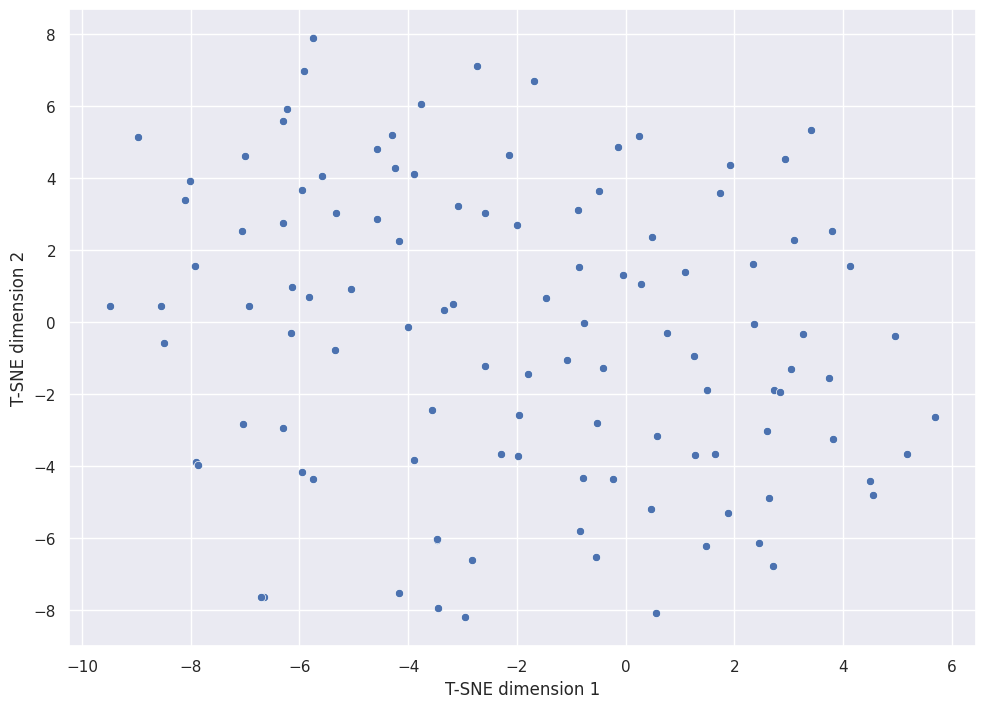

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], legend='full')
plt.xlabel('T-SNE dimension 1')
plt.ylabel('T-SNE dimension 2')
plt.show()
